## Contexto

Este trabajo tiene por objeto analizar y predecir algunas de las series que componen el Índice de Precios al Consumo (IPC), el cual es un indicador del nivel general de precios de bienes y servicios que los hogares adquieren dentro del territorio nacional. Su variación a lo largo del tiempo es una aproximación de la variación en el costo de vida, y su control es uno de los objetivos de la política macroeconómica y monetaria de los países.

La serie de índices de precios se inició en el año 1914 a partir de estudios sobre las condiciones de vida de la población, pero no fue hasta 1963 que se produjo el primer índice elaborado a partir de la información de una encuesta de gastos del consumo de los hogares. Desde entonces, los sucesivos cambios de base tienen por objetivo actualizar la composición y estructura de la canasta de consumo, con el fin de reflejar de la mejor manera posible los verdaderos niveles de gastos de la ciudadanía. El último cambio de base (Octubre 2022) establece una nueva canasta de referencia, la cual se construyó en base a la Encuesta de Gastos e Ingresos de los Hogares (ENGIH) realizada entre los meses de Noviembre de 2016 y Octubre de 2017.

Se divide en dos grupos, donde cada uno de ellos esta compuesto por distintas series económicas:

* IPC de Bienes Transables: Los bienes transables son todos aquellos bienes que pueden ser exportables y/o importables. Las siguientes son las series que lo componen y su peso relativo:
  * Alimentos y bebidas no alcohólicas (25.85 %)
  * Bebidas alcohólicas, tabaco y narcóticos (3.64 %)
  * Ropa y Calzado (2.91 %)
  * Mobiliario, enseres domésticos, y demás artículos regulares de los hogares (5.42 %)

* IPC de Bienes No Transables: Los bienes no transables son aquellos productos o servicios que no se pueden fácilmente intercambiar entre economías debido a su naturaleza o características específicas. Estos bienes son típicamente consumidos localmente. Las series que lo componen y su peso relativos son:
  * Vivienda, agua, electricidad, gas, y otros combustibles (13.00 %)
  * Salud (3.85 %)
  * Transporte (11.67 %)
  * Información y Comunicación (6.18 %)
  * Recreación, deporte y cultura (5.66 %)
  * Servicios de Educacion (3.46 %)
  * Restaurantes y servicios de alojamiento (8.31 %)
  * Seguros y servicios financieros (5.69 %)
  * Cuidado personal, protección social y bienes diversos (4.35 %)

En el cuadro al final del siguiente link se pueden comprobar las ponderaciones mencionadas (ver sección "Total Pais"):

[INE, Informes IPC](https://www5.ine.gub.uy/documents/Estad%C3%ADsticasecon%C3%B3micas/HTML/IPC/2023/Informe-IPC-MAYO-2023.html)

### Algunos otros usos del IPC
  * Deflactar magnitudes monetarias a efectos de expresarlas en términos reales
  * Ajustar unidades de cuenta como la Unidad Indexada (UI), o la Base de Prestaciones y Contribuciones (BPC).
  * Indexar ingresos, prestaciones y contribuciones a la seguridad social,
  * Indexar precios de contratos, valores de activos financieros, tarifas y tramos impositivos.

### Transformaciones Box-Cox
A lo largo de este trabajo, y con el objetivo de mejorar las predicciones, se utilizarán transformaciones Box-Cox, las cuales permiten corrigir la asimetría de una variable, varianzas diferentes o la no linealidad entre variables. Es en consecuencia, un mecanismo muy útil para transformar una variable y obtener una nueva que siga una distribución normal.
Éstas transformaciones vienen dadas para diferentes valores de lambda por la siguiente expresión:

![Formaula Box-Cox](box-cox.JPG)

siendo x la variable a ser transformada y lambda el parámetro de transformación. 

Las transformaciones más habituales se describen en la siguiente tabla:

![Tabla Box-Cox](tabla-box-cox.JPG)

Cuando el parámetro de la transformación estimada es cercano a los valores de la tabla anterior, es recomendable utilizar el valor de exacto de la tabla, ya que será más sencillo de interpretar.

## Objetivos

1. Seleccionar cuatro de las trece series que componen el IPC (idealmente que presenten comportamientos diferentes entre sí).
2. Con los datos hasta Octubre 2022 ajustar modelos con algoritmo autoarima. Predecir para el período Nov22-Mayo23.
3. Analizar las series y en base a sus características proponer modelos alternativos.
4. Reducir el error de los modelos propuestos vs aquellos generados con el algoritmo autoarima. 

In [1]:
# Cargo las librerias necesarias
library(astsa)
suppressMessages(library(forecast))
library(tseries)
library(keras)
options(repr.plot.width=16, repr.plot.height=6)
set.seed(100)

## 1. Elección de series

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1966326,105.1,3958902,211.5,2517932,134.5
Vcells,3335729,25.5,8388608,64.0,6806899,52.0


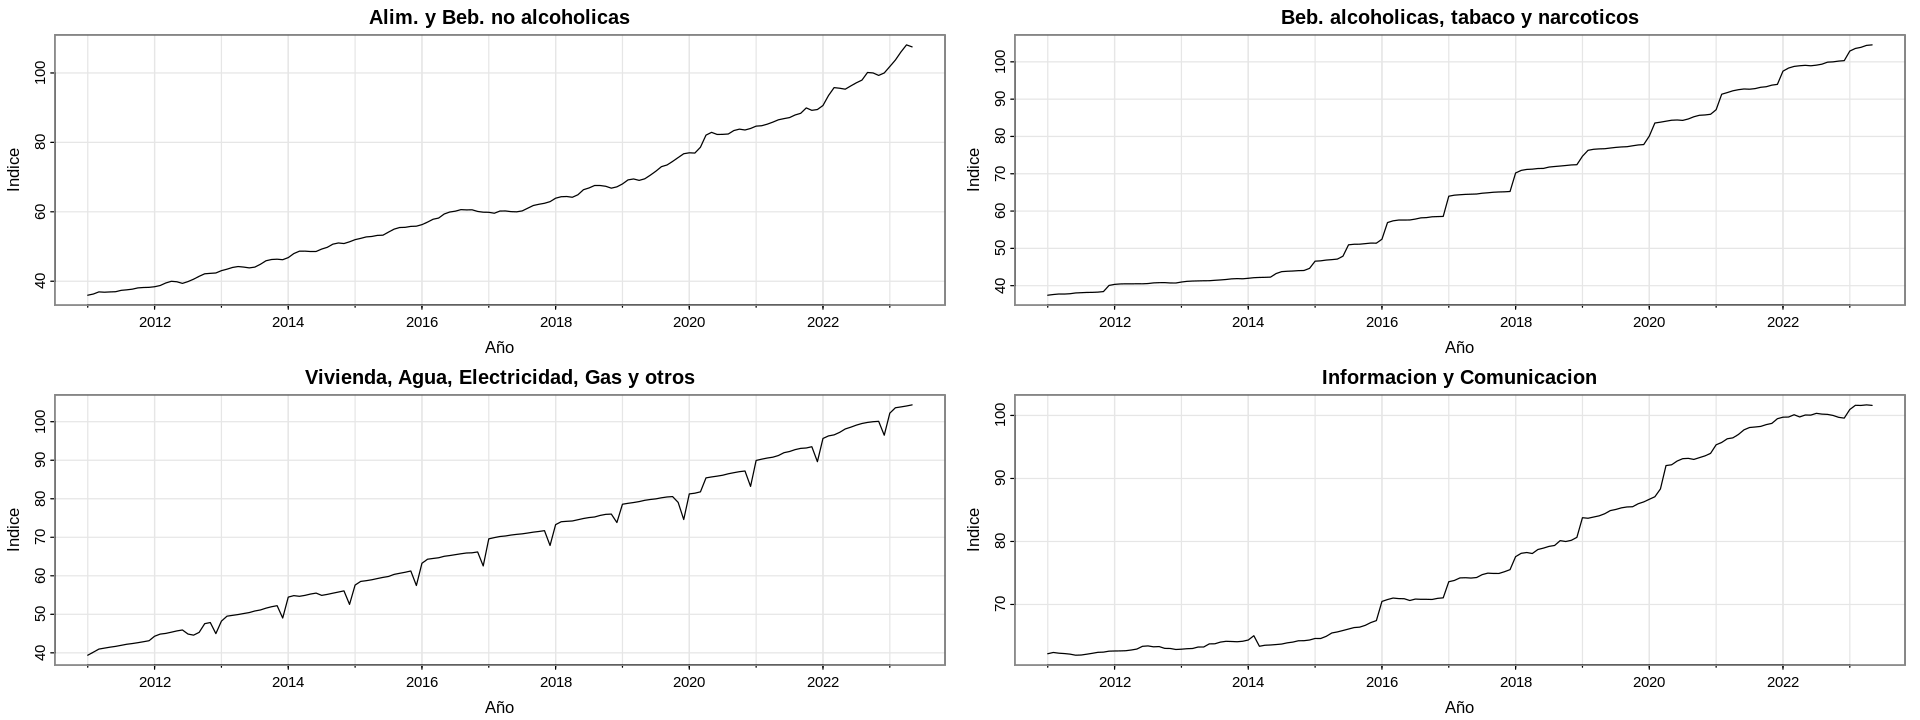

In [2]:
rm(list=ls())
gc()

# Cargo los datos de un csv que previamente fue subido a github
df <- read.csv("Series.csv", sep=";")
df <- na.omit(df)

# Elijo 4 series (dos de Transables y dos de No Transables) que sean lo mas diferentes posibles 
serie1 <- ts(data=df$Alimentos.Y.Bebidas.No.Alcohólicas, start = 2011, frequency=12)
serie2 <- ts(data=df$Bebidas.Alcohólicas..Tabaco.Y.Narcóticos, start = 2011, frequency=12)
serie3 <- ts(data=df$Vivienda..Agua..Electricidad..Gas.Y.Otros.Combustibles, start = 2011, frequency=12)
serie4 <- ts(data=df$Información.Y.Comunicación, start = 2011, frequency=12)

nombres <- list("Alim. y Beb. no alcoholicas",
                "Beb. alcoholicas, tabaco y narcoticos",
                "Vivienda, Agua, Electricidad, Gas y otros",
                "Informacion y Comunicacion")
series <- list("serie1","serie2","serie3","serie4")

# Grafico las series elegidas
par(mfrow=c(2,2))
for(i in 1:length(series)){
  tsplot(get( as.character(series[i]) ), 
         main=nombres[[i]],
         ylab="Indice", xlab="Año")
}

#### Genero los grupos de Train y Validation

In [3]:
# Genero las series para train y validation
largo_series <- nrow(df)
meses_a_pred <- 7
serie1_train <- ts(serie1[ 1:(largo_series-meses_a_pred) ], start = 2011, frequency=12)
serie2_train <- ts(serie2[ 1:(largo_series-meses_a_pred) ], start = 2011, frequency=12)
serie3_train <- ts(serie3[ 1:(largo_series-meses_a_pred) ], start = 2011, frequency=12)
serie4_train <- ts(serie4[ 1:(largo_series-meses_a_pred) ], start = 2011, frequency=12)
serie1_validation <- ts(tail(serie1, meses_a_pred), start=2022 + 10/12 , frequency=12)
serie2_validation <- ts(tail(serie2, meses_a_pred), start=2022 + 10/12 , frequency=12)
serie3_validation <- ts(tail(serie3, meses_a_pred), start=2022 + 10/12 , frequency=12)
serie4_validation <- ts(tail(serie4, meses_a_pred), start=2022 + 10/12 , frequency=12)

dates <- seq(as.Date("2022-11-01"), by = "month", along = serie1_validation)

vector_series_tr <- list("serie1_train", "serie2_train", "serie3_train", "serie4_train")
vector_series_val <- list("serie1_validation", "serie2_validation", "serie3_validation", "serie4_validation")

## 2. Ajuste de las series con algoritmo autoarima

[1] "Alim. y Beb. no alcoholicas --> se ajusta con ARIMA(2,2,3)(1,0,0)[12]"
[1] "Beb. alcoholicas, tabaco y narcoticos --> se ajusta con ARIMA(0,1,1)(1,1,1)[12]"
[1] "Vivienda, Agua, Electricidad, Gas y otros --> se ajusta con ARIMA(1,1,1)(0,1,1)[12]"
[1] "Informacion y Comunicacion --> se ajusta con ARIMA(0,2,1)(1,0,1)[12]"


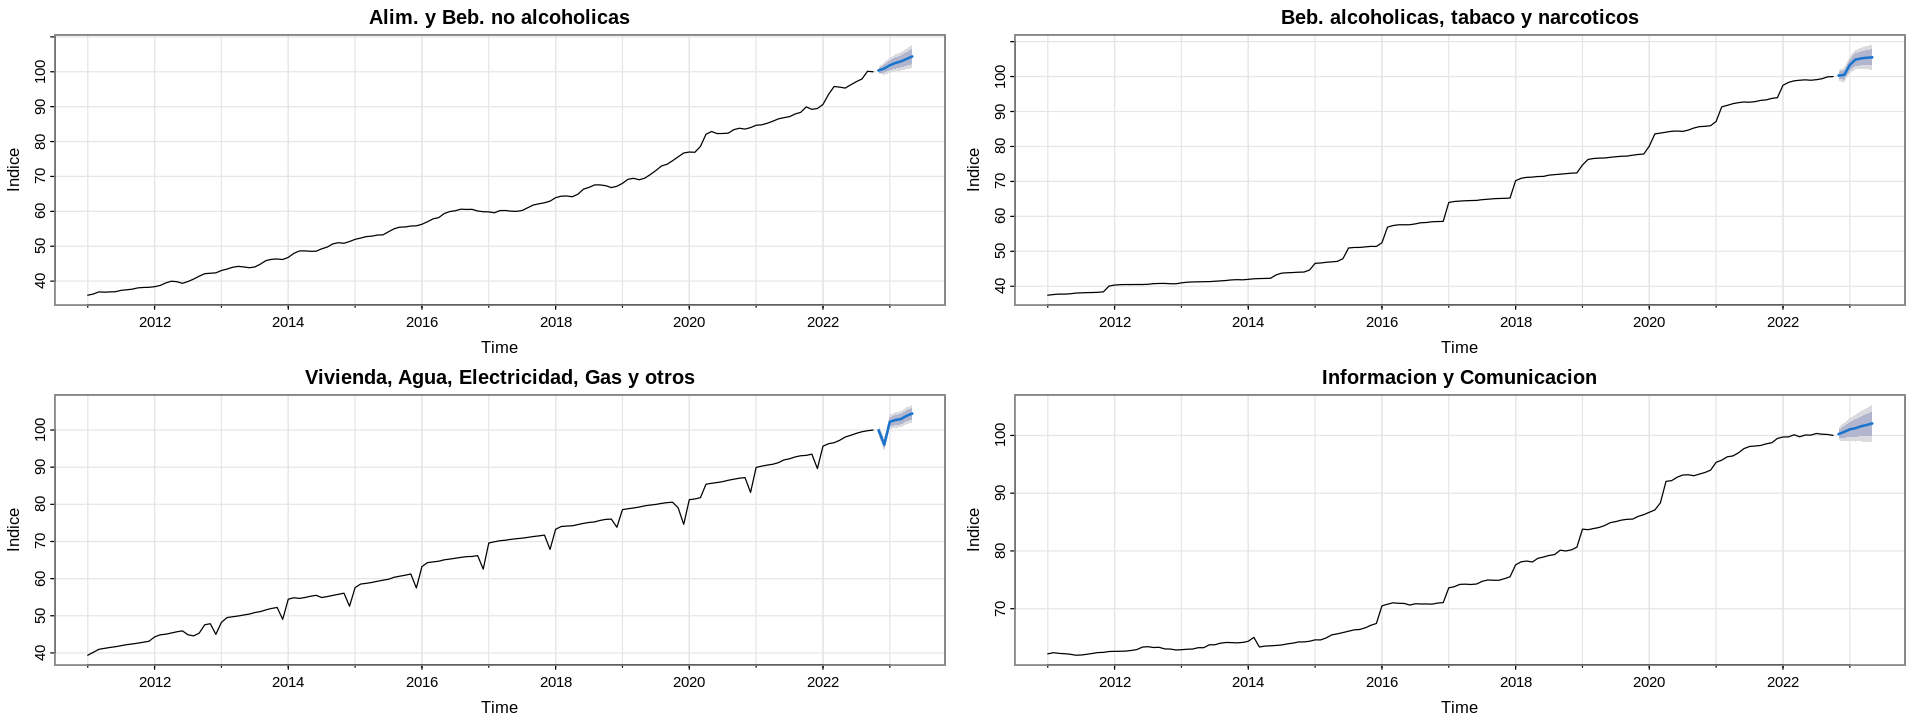

In [4]:
# Entreno las series con algoritmos auto.arima, y genero las predicciones
vector_series_tr <- list("serie1_train", "serie2_train", "serie3_train", "serie4_train")
vector_series_val <- list("serie1_validation", "serie2_validation", "serie3_validation", "serie4_validation")

vector_modelos <- list() 
vector_ajustes <- list()
vector_arima_orders <- list()
vector_predicciones <- list()
rmse_train <- list()
rmse_val <- list() # aquí se guardará el rmse de cada auto arima

# Grafico las predicciones con su intervalo de confianza
par(mfrow=c(2,2))
for(i in 1:length(vector_series_tr)){
    r <- get(vector_series_tr[[i]])
    fit <- auto.arima(r)
    vector_modelos[[i]] <- fit
    vector_ajustes[[i]] <- fitted(fit)
    vector_arima_orders[[i]] <- arimaorder(fit)
    vector_predicciones[[i]] <- forecast(vector_modelos[[i]], h=meses_a_pred)
    print(paste(nombres[[i]], "--> se ajusta con", vector_predicciones[[i]]$method ))
    rmse_train[[i]] <- sd(fitted(fit) - get(vector_series_tr[[i]]))
    rmse_val[[i]] <- sd(vector_predicciones[[i]]$mean - get(vector_series_val[[i]]))
    tsplot(vector_predicciones[[i]], main=nombres[[i]], ylab="Indice")
    text(x=dates[6], y=92, paste("RMSE_train:", round(rmse_train[[i]],4)), pos = 3, col = "steelblue", cex = 1.5, font = 2)
}

### 3.4 Información y Comunicaciòn

In [5]:
serie4_train <- ts(diff(serie4), start=2011 + (1/12), end=2022 + (9/12), frequency=12)
serie4_validation <- tail(diff(serie4), 10)

In [6]:
window <- 3 # ventana de entrenamiento
pred <- 1 # periodos a predecir
n <- length(serie4_train)

x_train <- matrix(0, nrow=n-window, ncol=window) # matriz de 0s 
y_train <- matrix(0, nrow=n-window, ncol=pred)

for (i in 1:(n-window-pred+1)){
  x_train[i,] <- serie4_train[i:(i+window-1)] # de 1a3, de 2a4, de 3a5, ... 
  y_train[i,] <- serie4_train[(i+window):(i+window+pred-1)] # 4, 5, 6, ...
}
x_train <- array(data = x_train, dim = c(n-window-pred+1, window, 1))

Genero los grupos Train y Validation

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_2 (Dense)                     (None, 3, 32)                   64          
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 3, 32)                   0           
________________________________________________________________________________
lstm (LSTM)                         (None, 16)                      3136        
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 16)                      0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 8)                       136         
________________________________________________________________________________
dropout 

loss       mse 
0.2915448 0.2915448

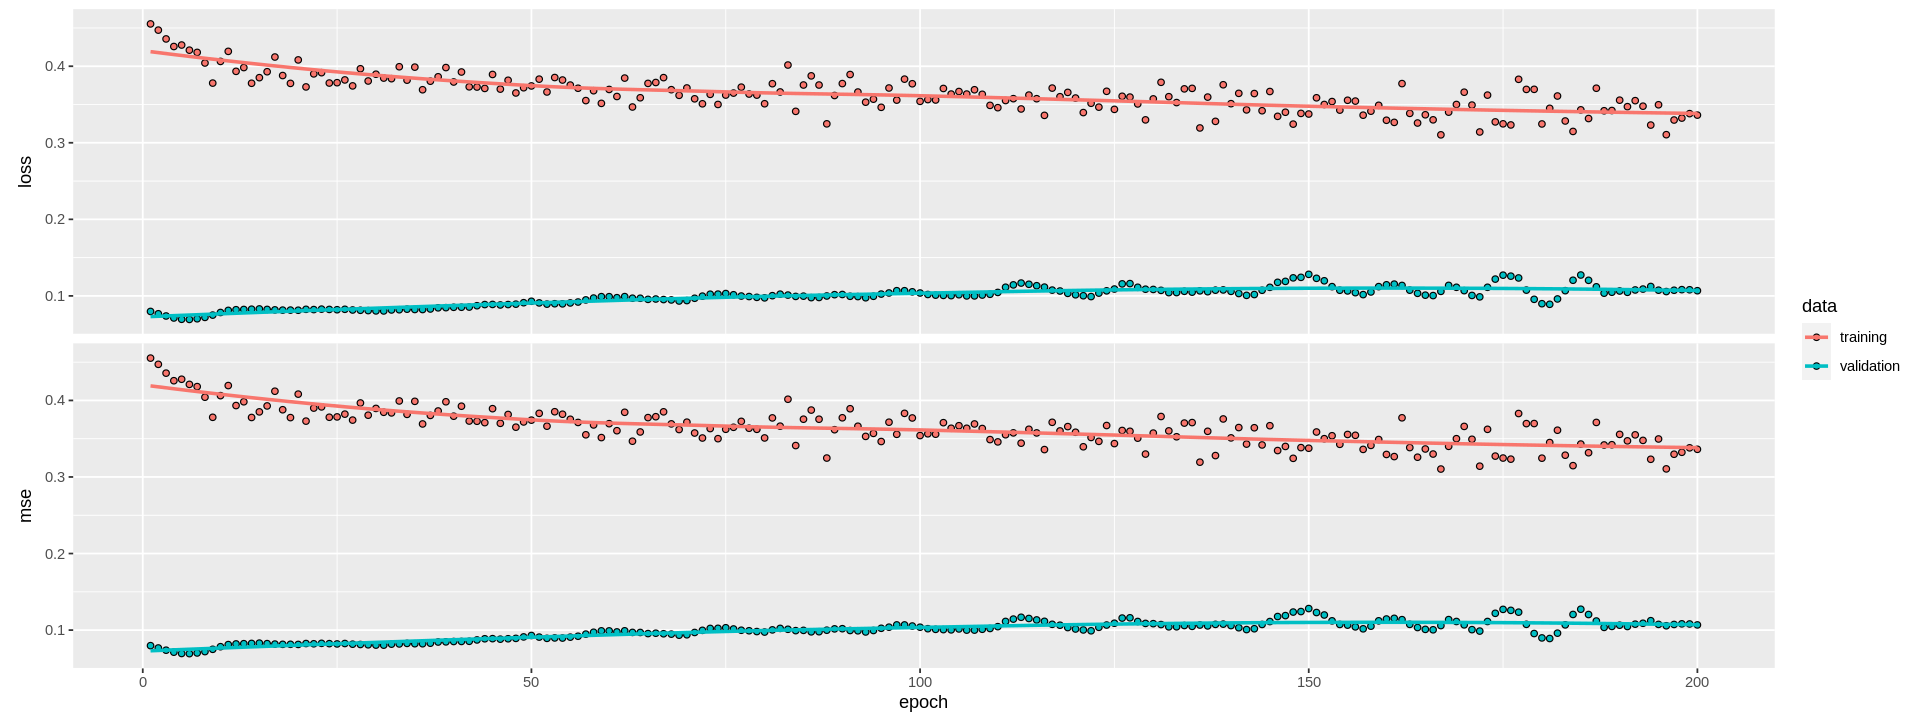

In [7]:
# LSTM
model_lstm <- keras_model_sequential()
model_lstm %>%
    layer_dense(input_shape=dim(x_train)[2:3], units=32, activation="relu") %>%
    layer_dropout(0.25) %>%
    layer_lstm(units=16, activation="relu") %>%
    layer_dropout(0.25) %>%
    layer_dense(units=8, activation="relu") %>%
    layer_dropout(0.25) %>%
    layer_dense(units=1)
summary(model_lstm)
model_lstm %>% compile(loss="mse",
                   optimizer="adam",
                   metrics=c("mse"))
trained_model_lstm <- model_lstm %>% fit(
  x = x_train,
  y = y_train,
  epochs = 200,
  validation_split=0.1
)
plot(trained_model_lstm)
evaluate(model_lstm, x_train, y_train)

### Prediccion sobre Validation

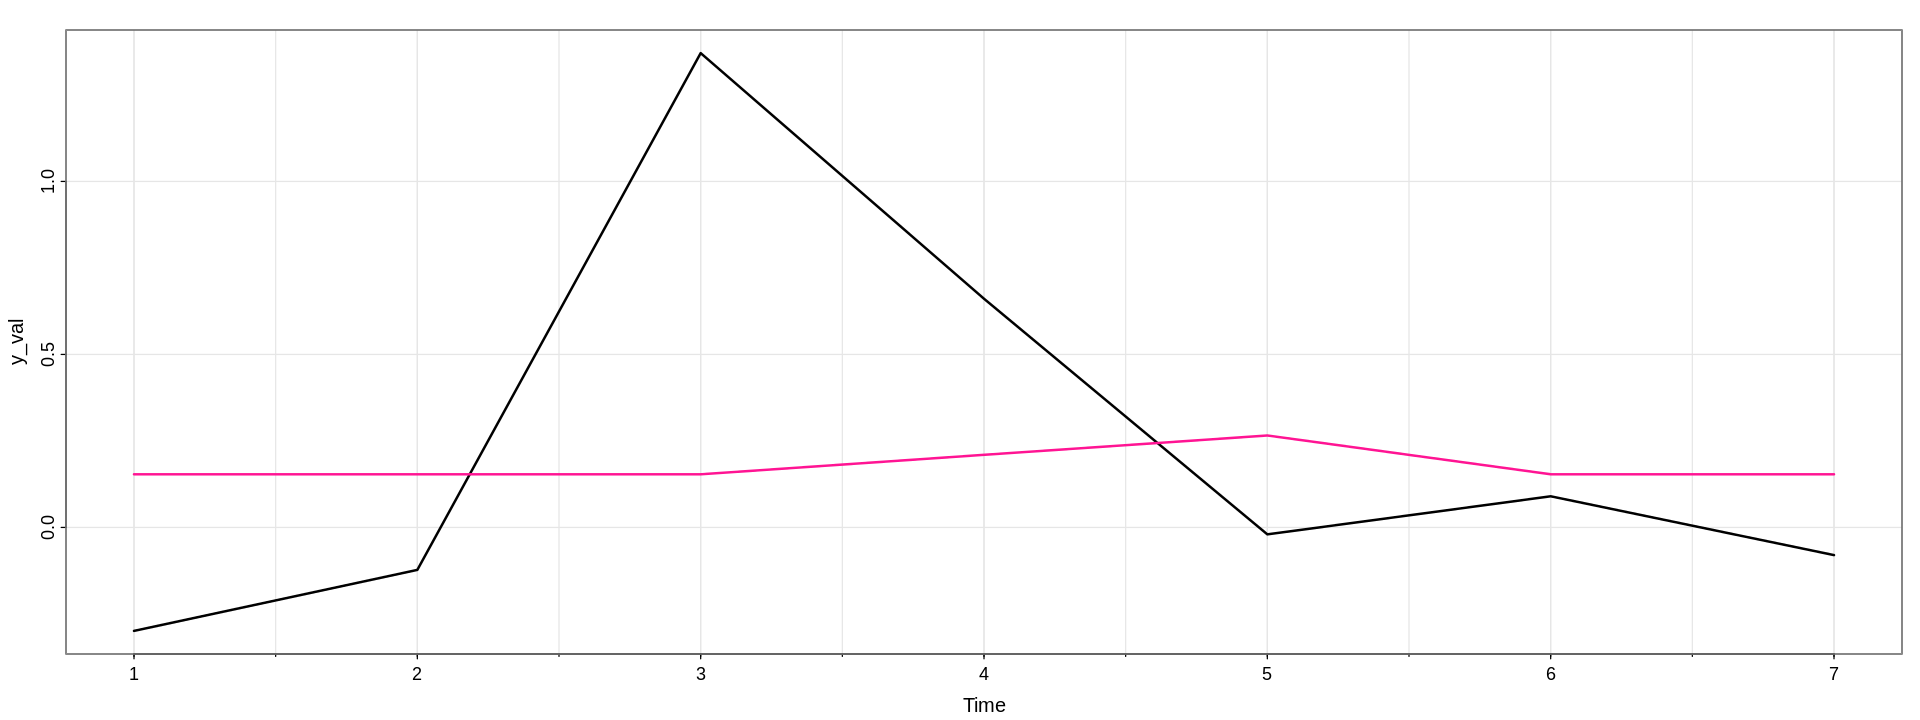

In [8]:
n <- length(serie4_validation)
x_val <- matrix(0, nrow=n-window, ncol=window) # matriz de 0s 
y_val <- matrix(0, nrow=n-window, ncol=pred)

for (i in 1:(n-window-pred+1)){
  x_val[i,] <- serie4_validation[i:(i+window-1)] 
  y_val[i,] <- serie4_validation[(i+window):(i+window+pred-1)] 
}
x_val <- array(data = x_val, dim = c(n-window-pred+1, window, 1))

pred <- predict(model_lstm, x_val)
tsplot(y_val, lwd=2)
lines(pred, col="deeppink", lwd=2)
# rmse_lstm <- sd(y_val - pred[,1])